In [29]:
import sys
if ".." not in sys.path:
    sys.path.insert(0, "..")

In [30]:
import warnings

import numpy as np
import pandas as pd
from cobra.io import read_sbml_model
from experiments.fast_dFBA import setup_drawdown
from utils.cobra_utils import get_or_create_exchange, set_active_bound

# Load the model
model = read_sbml_model("../model/Rpom_05.xml")
setup_drawdown(model)
ex_glc = model.reactions.get_by_id("EX_glc")
ex_ace = get_or_create_exchange(model, "ACET[e]")

# TODO: Remove all of the below
# Turn on maintenance
atpm = model.reactions.get_by_id("ATPM")
atpm.bounds = (25, 25)

EX_L-ALPHA-ALANINE[e]: L-ALPHA-ALANINE[e] <=>  : (-5, 1000.0)
EX_L-ASPARTATE[e]: L-ASPARTATE[e] <=>  : (-5, 1000.0)
EX_glt: GLT[e] <=>  : (-5, 1000.0)
EX_LEU[e]: LEU[e] <=>  : (-5, 1000.0)
EX_PHE[e]: PHE[e] <=>  : (-5, 1000.0)
EX_PRO[e]: PRO[e] <=>  : (-5, 1000.0)
EX_VAL[e]: VAL[e] <=>  : (-5, 1000.0)
EX_CPD-12693[e]: CPD-12693[e] <--  : (-5, 0.0)
EX_TYR[e]: TYR[e] <=>  : (-5, 1000.0)


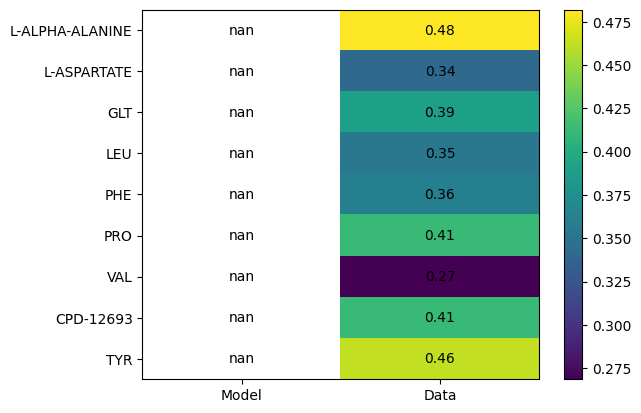

In [31]:
import matplotlib.pyplot as plt
from gem2cue import utils as cue
from cobra import Reaction, Metabolite

# Load BGE data
bge_data = pd.read_csv("../data/clean/growth/BGE_DSS3.csv")

# Get model BGE
model_bge = []
data_bge = []
substrates = []

co2_exchange="EX_co2"
ex_glc = model.reactions.get_by_id("EX_glc")
ex_ace = model.reactions.get_by_id("EX_ac")
for substrate, bge in zip(bge_data["ID"], bge_data["BGE"]):
    # Record substrate
    substrates.append(substrate)

    # Record data bge
    data_bge.append(bge)

    # Record model BGE
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        with model:
            # Get internal metabolite
            met_c = model.metabolites.get_by_id(substrate + "[c]")

            # Get periplasmic metabolite, if it exists
            try:
                met_p = model.metabolites.get_by_id(f"{substrate}[p]")
            except:
                met_p = None

            # Get or create external metabolite
            try:
                met_e = model.metabolites.get_by_id(f"{substrate}[e]")
            except:
                met_e = Metabolite(f"{substrate}[e]",
                                   formula=met_c.formula,
                                   name=substrate,
                                   compartment="e")
                model.add_metabolites([met_e])

            # Set the substrate uptake rate
            set_active_bound(ex_glc, 0)
            set_active_bound(ex_ace, 0)
            ex_substrate = get_or_create_exchange(model, f"{substrate}[e]")
            set_active_bound(ex_substrate, 5)
            print(f"{ex_substrate} : {ex_substrate.bounds}")

            # Create a free transport reaction, if there isn't one
            # TODO: add actual transport reactions
            has_transport = False
            for reaction in model.reactions:
                if met_e in reaction.metabolites:
                    if met_p in reaction.metabolites or met_c in reaction.metabolites:
                        has_transport = True
                        break

            if not has_transport:
                transport = Reaction("test", "", lower_bound=-1000, upper_bound=1000)
                transport.add_metabolites({
                    met_e : -1,
                    met_c : 1
                })
                model.add_reactions([transport])

            sol = model.optimize()
            if sol.status != "infeasible":
                c_ex_rxns = cue.get_c_ex_rxns(model)

                c_uptake, c_secret = cue.get_c_ex_rxn_fluxes(sol, c_ex_rxns, "cobrapy")
                bge_model = cue.calculate_cue(c_uptake, c_secret, co2_exchange)
                model_bge.append(bge_model if bge_model is not None else float("nan"))
            else:
                model_bge.append(float("nan"))

# Plot model vs data BGE
fig, ax = plt.subplots()
img = ax.imshow(np.array([model_bge, data_bge]).T, cmap="viridis", aspect="auto")
for i, (_model_bge, _data_bge) in enumerate(zip(model_bge, data_bge)):
    ax.text(0, i, f"{_model_bge:.2f}", ha="center", va="center", color="black")
    ax.text(1, i, f"{_data_bge:.2f}", ha="center", va="center", color="black")

ax.set_xticks(range(2), ["Model", "Data"])
ax.set_yticks(range(len(substrates)), substrates)

fig.colorbar(img)

In [32]:
# Testing bed
# =============================================================================

substrate = "L-ASPARTATE"

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    with model:
        # Get internal metabolite
        met_c = model.metabolites.get_by_id(substrate + "[c]")

        # Get periplasmic metabolite, if it exists
        try:
            met_p = model.metabolites.get_by_id(f"{substrate}[p]")
        except:
            met_p = None

        # Get or create external metabolite
        try:
            met_e = model.metabolites.get_by_id(f"{substrate}[e]")
        except:
            met_e = Metabolite(f"{substrate}[e]",
                               formula=met_c.formula,
                               name=substrate,
                               compartment="e")
            model.add_metabolites([met_e])

        # Set the substrate uptake rate
        set_active_bound(ex_glc, 0)
        set_active_bound(ex_ace, 0)
        ex_substrate = get_or_create_exchange(model, f"{substrate}[e]")
        set_active_bound(ex_substrate, 3)
        print(f"{ex_substrate} : {ex_substrate.bounds}")

        # Create a free transport reaction, if there isn't one
        # TODO: add actual transport reactions
        has_transport = False
        for reaction in model.reactions:
            if met_e in reaction.metabolites:
                if met_p in reaction.metabolites or met_c in reaction.metabolites:
                    has_transport = True
                    break

        if not has_transport:
            transport = Reaction("test", "", lower_bound=-1000, upper_bound=1000)
            transport.add_metabolites({
                met_e : -1,
                met_c : 1
            })
            model.add_reactions([transport])

        sol = model.optimize()
        if sol.status != "infeasible":
            assert ex_substrate in model.exchanges
            c_ex_rxns = cue.get_c_ex_rxns(model)
            assert ex_substrate in model.exchanges

            c_uptake, c_secret = cue.get_c_ex_rxn_fluxes(sol, c_ex_rxns, "cobrapy")
            bge_model = cue.calculate_cue(c_uptake, c_secret, co2_exchange)
        else:
            bge_model = 0
        
        print(met_c.summary())

print(f"Solver status: {sol.status}")
print(f"Growth rate: {sol.objective_value}")
print(f"Model BGE: {bge_model}")
print(f"Data BGE: {bge_data.loc[bge_data['ID'] == substrate, 'BGE'].values[0]}")
print(f"Uptake fluxes: {c_uptake}")
print(f"Secretion fluxes: {c_secret}")


EX_L-ASPARTATE[e]: L-ASPARTATE[e] <=>  : (-3, 1000.0)


Infeasible: None (infeasible).

PRO: 100%|██████████| 441/441 [00:21<00:00, 20.05it/s]


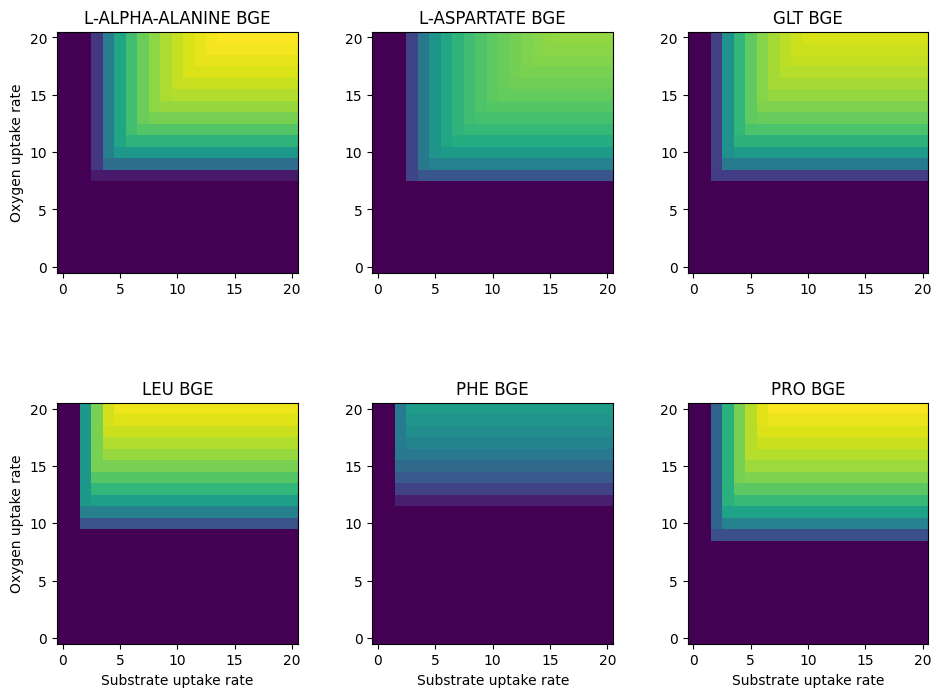

In [7]:
from tqdm import tqdm

fig, axs = plt.subplots(2, 3)

max_bge = 0
for substrate, ax in zip(substrates[:-3], axs.flat):
    # Get oxygen exchange
    ex_o2 = model.reactions.get_by_id("EX_o2")

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        with model:
            # Get internal metabolite
            met_c = model.metabolites.get_by_id(substrate + "[c]")

            # Get periplasmic metabolite, if it exists
            try:
                met_p = model.metabolites.get_by_id(f"{substrate}[p]")
            except:
                met_p = None

            # Get or create external metabolite
            try:
                met_e = model.metabolites.get_by_id(f"{substrate}[e]")
            except:
                met_e = Metabolite(f"{substrate}[e]",
                                   formula=met_c.formula,
                                   name=substrate,
                                   compartment="e")
                model.add_metabolites([met_e])

            # Create a free transport reaction, if there isn't one
            # TODO: add actual transport reactions
            has_transport = False
            for reaction in model.reactions:
                if met_e in reaction.metabolites:
                    if met_p in reaction.metabolites or met_c in reaction.metabolites:
                        has_transport = True
                        break

            if not has_transport:
                transport = Reaction(
                    "test", "", lower_bound=-1000, upper_bound=1000)
                transport.add_metabolites({
                    met_e: -1,
                    met_c: 1
                })
                model.add_reactions([transport])

            # Get exchange reaction
            ex_substrate = get_or_create_exchange(model, f"{substrate}[e]")

            # Calculate BGE for each combination of substrate and oxygen uptake rates
            X, Y = np.meshgrid(np.arange(21), np.arange(21))
            Z = np.zeros((21, 21))

            with tqdm(total=X.size, desc=substrate) as pbar:
                for i, substrate_uptake in enumerate(X[0]):
                    for j, o2_uptake in enumerate(Y[:, 0]):
                        set_active_bound(ex_substrate, substrate_uptake)
                        set_active_bound(ex_o2, o2_uptake)
                        sol = model.optimize()
                        if sol.status != "infeasible":
                            c_ex_rxns = cue.get_c_ex_rxns(model)
                            c_uptake, c_secret = cue.get_c_ex_rxn_fluxes(
                                sol, c_ex_rxns, "cobrapy")
                            bge_model = cue.calculate_cue(
                                c_uptake, c_secret, co2_exchange)
                        else:
                            bge_model = 0

                        Z[j, i] = bge_model
                        if bge_model > max_bge:
                            max_bge = bge_model

                        pbar.update(1)

        ax.imshow(Z,
                       cmap="viridis",
                       aspect="equal",
                       origin="lower",
                       vmin=0,
                       vmax=max_bge,
                       interpolation="none")
        ax.set_title(f"{substrate} BGE")

for ax in axs[:, 0]:
    ax.set_ylabel("Oxygen uptake rate")

for ax in axs[-1, :]:
    ax.set_xlabel(f"Substrate uptake rate")


fig.tight_layout()
fig.set_size_inches(10, 8)